In [10]:
from agents.ppoTrader import TraderPPO
import gym
from gym import spaces
import numpy as np
import torch
import pandas as pd
import ta

In [11]:
class TimeSeriesEnvOHLC(gym.Env):
    def __init__(self, data, window_size=96, verbose= False):
        super(TimeSeriesEnvOHLC, self).__init__()
        self.window_size = window_size
        self.verbose = verbose
        self.df = data.copy()
        
        # Wskaźniki techniczne
        self.df['SMA'] = ta.trend.sma_indicator(self.df['close'], window=14)
        self.df['EMA'] = ta.trend.ema_indicator(self.df['close'], window=14)
        self.df['RSI'] = ta.momentum.rsi(self.df['close'], window=14)
        self.df['MACD'] = ta.trend.macd_diff(self.df['close'])
        self.df['BB_upper'] = ta.volatility.bollinger_hband(self.df['close'])
        self.df['BB_lower'] = ta.volatility.bollinger_lband(self.df['close'])
        median_price = (self.df['high'] + self.df['low']) / 2
        self.df['MOM'] = median_price.rolling(window=5).mean() - median_price.rolling(window=34).mean()
        self.df.fillna(0.0, inplace=True)
        
        self.ohlc_data = self.df[['open', 'high', 'low', 'close',
                                  'SMA', 'EMA', 'RSI', 'MACD',
                                  'BB_upper', 'BB_lower', 'MOM']].values
        
        self.current_step = window_size
        
        # Action space: 0=hold, 1=buy/long, 2=sell/short
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(
            low=0.0, high=1.0, 
            shape=(window_size, self.ohlc_data.shape[1]), 
            dtype=np.float32
        )
        
        self.min_val = np.min(self.ohlc_data, axis=0)
        self.max_val = np.max(self.ohlc_data, axis=0)
        
        self.initial_cash = 100_000.0
        self.cash = self.initial_cash
        self.long_inventory = []   # list of entry prices
        self.short_inventory = []  # list of entry prices
        self.total_profit = 0.0
        self.last_portfolio_value = self.initial_cash
        self.states_buy = []
        self.states_sell = []
    
    def reset(self):
        self.current_step = self.window_size
        self.cash = self.initial_cash
        self.long_inventory = []
        self.short_inventory = []
        self.total_profit = 0.0
        self.last_portfolio_value = self.initial_cash
        self.states_buy = []
        self.states_sell = []
        return self._get_observation()
    
    def _get_observation(self):
        window = self.ohlc_data[self.current_step - self.window_size:self.current_step]
        min_val = np.min(window, axis=0)
        max_val = np.max(window, axis=0)
        norm_window = (window - min_val) / (max_val - min_val + 1e-8)
        return norm_window.astype(np.float32)
    
    def _calculate_portfolio_value(self, price):
        """Calculate total portfolio value: cash + unrealized P/L"""
        portfolio_value = self.cash
        
        # Unrealized profit from long positions
        for long_entry in self.long_inventory:
            portfolio_value += (price - long_entry)
        
        # Unrealized profit from short positions
        for short_entry in self.short_inventory:
            portfolio_value += (short_entry - price)
        
        return portfolio_value
    
    def step(self, action):
        done = False
        price = self.ohlc_data[self.current_step][3]
        prev_price = self.ohlc_data[self.current_step - 1][3]

        action_name = ['HOLD', 'BUY', 'SELL'][action]
        profit = 0.0

        # --- ACTION LOGIC ---
        if action == 1:  # BUY / LONG
            if len(self.short_inventory) > 0:
                # Zamknij pozycję krótką
                short_entry = self.short_inventory.pop(0)
                profit = short_entry - price
                self.cash += profit
                self.total_profit += profit
            else:
                # Otwórz pozycję długą
                self.long_inventory.append(price)
                self.states_buy.append(self.current_step)

        elif action == 2:  # SELL / SHORT
            if len(self.long_inventory) > 0:
                # Zamknij pozycję długą
                long_entry = self.long_inventory.pop(0)
                profit = price - long_entry
                self.cash += profit
                self.total_profit += profit
            else:
                # Otwórz pozycję krótką
                self.short_inventory.append(price)
                self.states_sell.append(self.current_step)

        # --- REWARD CALCULATION ---
        current_portfolio_value = self._calculate_portfolio_value(price)
        delta_price = (price - prev_price) / (prev_price + 1e-8)

        # Jeśli agent ma longi — zysk przy wzroście ceny
        long_exposure = len(self.long_inventory)
        short_exposure = len(self.short_inventory)

        # nagroda za trafienie kierunku trendu
        reward = (
            delta_price * long_exposure      # nagroda gdy long i cena rośnie
            - delta_price * short_exposure   # nagroda gdy short i cena spada
        )

        # bonus za zamknięcie zyskiem
        reward += profit / (prev_price + 1e-8)

        # mała kara za częsty handel
        if action != 0:
            reward -= 0.001

        self.last_portfolio_value = current_portfolio_value
        self.current_step += 1

        # --- DONE CONDITION ---
        if self.current_step >= len(self.ohlc_data):
            done = True
            final_price = self.ohlc_data[-1][3]

            # Zamknij wszystkie pozycje
            for long_entry in self.long_inventory:
                profit = final_price - long_entry
                self.cash += profit
                self.total_profit += profit

            for short_entry in self.short_inventory:
                profit = short_entry - final_price
                self.cash += profit
                self.total_profit += profit

            if self.verbose:
                print(f"{'='*110}")
                print(f"DONE | Final Portfolio: {self.cash:12.2f} | "
                    f"Total P/L: {self.total_profit:+10.2f} | "
                    f"Total Trades: {len(self.states_buy) + len(self.states_sell)}")
                print(f"{'='*110}")

        # --- LOG ---
        if self.verbose and self.current_step % 100 == 0:
            print(f"Step: {self.current_step:4d} | Action: {action_name:4s} | "
                f"Price: {price:8.2f} | Reward: {reward:+8.6f} | "
                f"Longs: {len(self.long_inventory):2d} | Shorts: {len(self.short_inventory):2d} | "
                f"Total P/L: {self.total_profit:+10.2f}")

        return self._get_observation(), float(reward), done


         open        high         low       close  volume
0  100.000000  100.407106   99.331123  100.000000     917
1  100.000000  101.319342   99.201344  101.253332     909
2  101.253332  102.835719  100.320579  102.486899     991
3  102.486899  103.792244  102.466761  103.681246     910
4  103.681246  105.625772  103.527462  104.817537     996


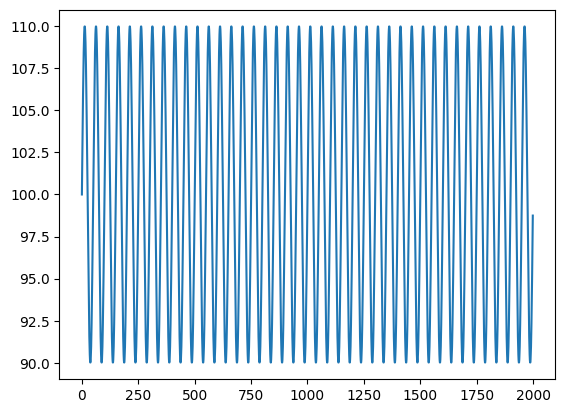

In [12]:
import numpy as np
import pandas as pd

def generate_sine_ohlc(n_steps=500, amplitude=10, base_price=100, noise_std=0.0, seed=42):
    np.random.seed(seed)
    t = np.arange(n_steps)
    
    # Close = sinus + szum
    close = base_price + amplitude * np.sin(2 * np.pi * t / 50) + np.random.normal(0, noise_std, n_steps)
    
    # Open = poprzednie close
    open_ = np.roll(close, 1)
    open_[0] = close[0]
    
    # High / Low = +/- losowy drobny zakres
    high = np.maximum(open_, close) + np.random.uniform(0, 1, n_steps)
    low = np.minimum(open_, close) - np.random.uniform(0, 1, n_steps)
    
    # Volume (opcjonalnie)
    volume = np.random.randint(900, 1000, n_steps)
    
    ohlc = pd.DataFrame({
        'open': open_,
        'high': high,
        'low': low,
        'close': close,
        'volume': volume
    })
    
    return ohlc

# Przykład
df = generate_sine_ohlc(n_steps=2000)
print(df.head())
import matplotlib.pyplot as plt
plt.plot(df['close'])


In [13]:
from utils.database import read_stock_data

# df = read_stock_data('AAOI')[0]
# df = df[['open', 'high', 'low', 'close', 'volume']]

In [14]:
# Długość całego zbioru
n = len(df)

# Proporcje
train_end = int(0.8 * n)

# Podziały
train_df = df.iloc[:train_end]
valid_df = df.iloc[train_end:]

env = TimeSeriesEnvOHLC(train_df, 96)
valid_env = TimeSeriesEnvOHLC(valid_df, 96)

env.reset()

array([[0.5       , 0.49766257, 0.49257845, ..., 0.        , 0.        ,
        0.50066644],
       [0.5       , 0.54167217, 0.48635814, ..., 0.        , 0.        ,
        0.50066644],
       [0.5627905 , 0.6148278 , 0.5400031 , ..., 0.        , 0.        ,
        0.50066644],
       ...,
       [0.07700135, 0.11138137, 0.10495277, ..., 0.87465644, 0.8353299 ,
        0.12264358],
       [0.11398166, 0.18548949, 0.11418217, ..., 0.8623372 , 0.84116846,
        0.16581875],
       [0.15704972, 0.22552906, 0.19022226, ..., 0.85191333, 0.8470517 ,
        0.21593772]], dtype=float32)

In [15]:
agent = TraderPPO()

In [ ]:
num_episodes = 50
from tqdm import tqdm

for episode in tqdm(range(num_episodes)):
    state = env.reset()
    done = False
    while not done:
        action, logp, value = agent.select_action(state)
        next_state, reward, done = env.step(action)
        agent.store_transition(state, action, reward, done, logp, value)
        state = next_state

    stats = agent.train()

  8%|▊         | 4/50 [00:16<03:04,  4.02s/it]

Łączny reward: -30.01 | Liczba kroków: 144


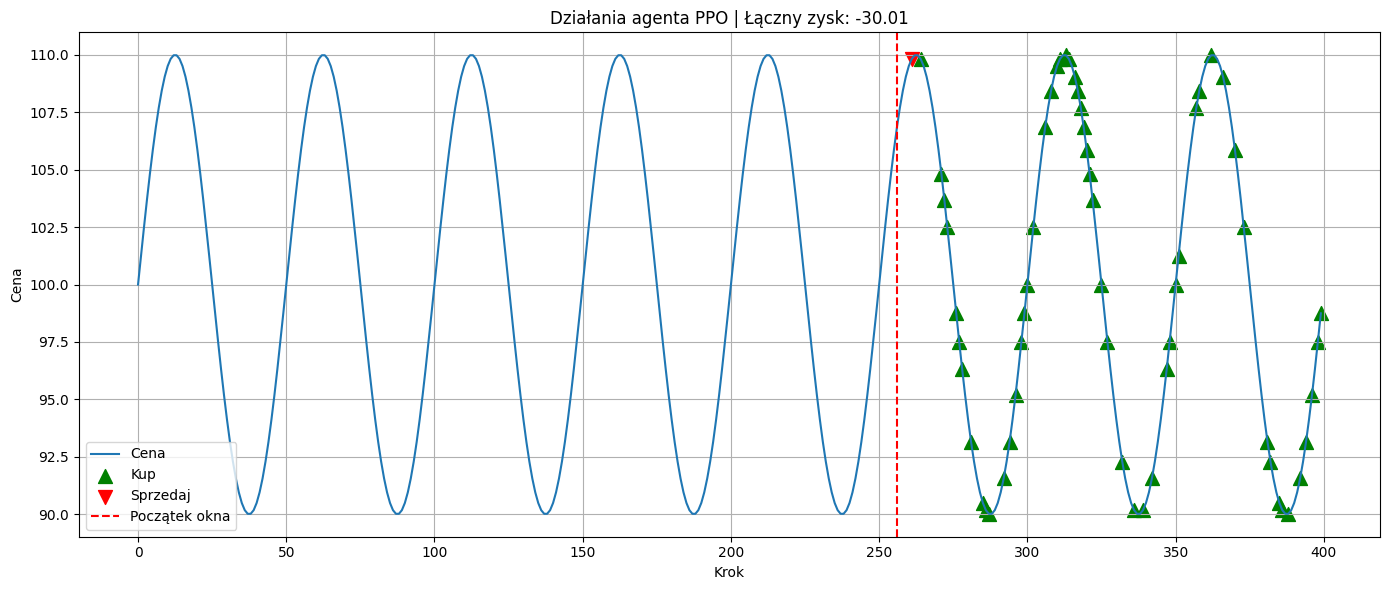

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def test_ppo_agent(env, agent, device="cuda:0"):
    """
    Testuje dyskretnego agenta PPO w środowisku OHLC
    i wizualizuje działania agenta.
    """
    state = env.reset()
    done = False
    total_reward = 0
    steps = 0

    # Wyzeruj stany kupna/sprzedaży
    env.states_buy = []
    env.states_sell = []

    while not done:
        # --- przygotowanie stanu ---
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

        # --- wybór akcji ---
        with torch.no_grad():
            features = agent.feature_extractor(state_tensor)
            logits = agent.actor(features)
            dist = torch.distributions.Categorical(logits=logits)
            action = dist.sample().item()  # 0=hold,1=long,2=short

        # --- wykonanie kroku w środowisku ---
        next_state, reward, done = env.step(action)

        total_reward += reward
        steps += 1
        state = next_state

    print(f"Łączny reward: {env.total_profit:.2f} | Liczba kroków: {steps}")

    # --- wizualizacja ---
    prices = env.ohlc_data[:, 3]
    buy_points = [i for i in env.states_buy if i < len(prices)]
    sell_points = [i for i in env.states_sell if i < len(prices)]
    profit = env.total_profit

    plt.figure(figsize=(14, 6))
    plt.plot(prices, label='Cena', linewidth=1.5)
    if buy_points:
        plt.scatter(buy_points, [prices[i] for i in buy_points],
                    color='green', marker='^', label='Kup', s=100)
    if sell_points:
        plt.scatter(sell_points, [prices[i] for i in sell_points],
                    color='red', marker='v', label='Sprzedaj', s=100)
    
    plt.title(f'Działania agenta PPO | Łączny zysk: {profit:.2f}')
    plt.axvline(x=env.window_size, color='red', linestyle='--', label='Początek okna')
    plt.xlabel('Krok')
    plt.ylabel('Cena')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

test_ppo_agent(valid_env, agent)

Łączny reward: 556.41 | Liczba kroków: 1344


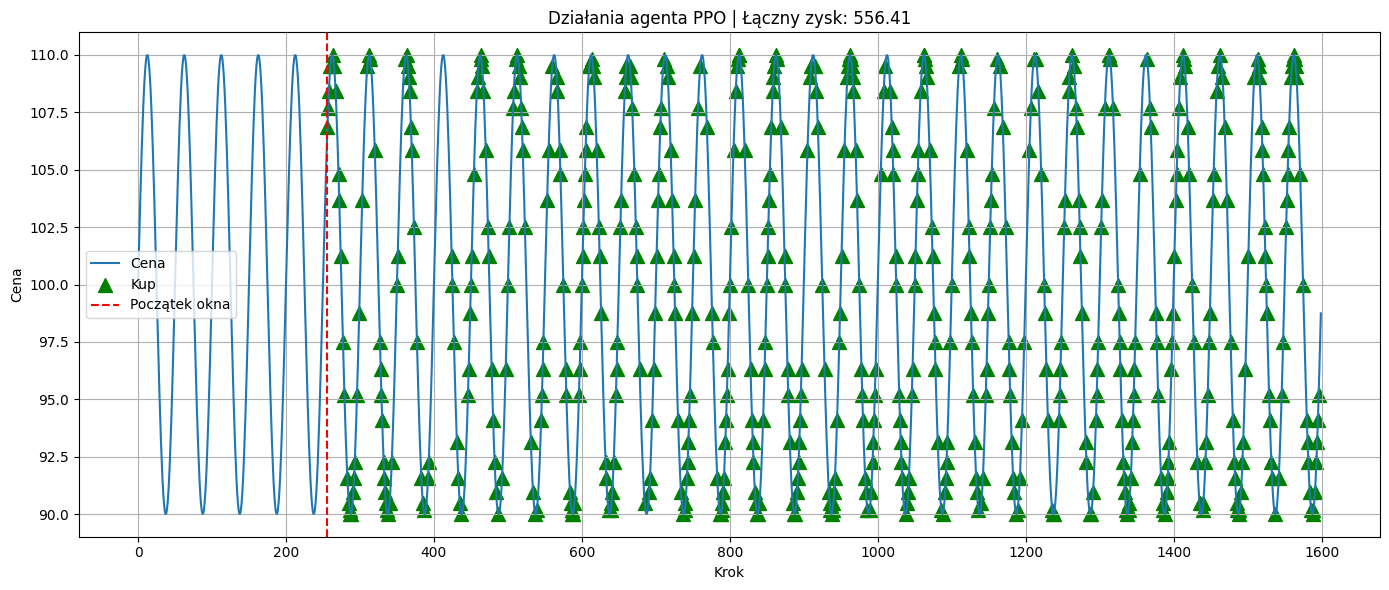

In [ ]:
test_ppo_agent(env, agent)